In [1]:
# Introduction

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal

from sklearn.model_selection import train_test_split

## Download the data
http://mindbigdata.com/opendb/index.html

In [3]:
# %%bash
# #Uncomment to download the data
# wget -q http://mindbigdata.com/opendb/MindBigData-IN-v1.06.zip
# mkdir -p DATA
# unzip -qq MindBigData-IN-v1.06.zip
# mv IN.txt DATA/
# rm MindBigData-IN-v1.06.zip

In [4]:
# Load and clean data

In [5]:
PATH_DATA="DATA/IN.txt"

with open(PATH_DATA,'r') as f:
    print(f.readline())

1142043	173652	IN	AF3	0	256	4259.487179,4237.948717,4247.179487,4242.051282,4233.333333,4251.282051,4232.820512,4234.358974,4224.615384,4219.487179,4249.743589,4238.461538,4245.641025,4244.615384,4223.076923,4240.512820,4234.358974,4240.512820,4235.384615,4224.102564,4255.384615,4243.589743,4243.589743,4248.205128,4226.666666,4244.102564,4228.717948,4225.641025,4236.923076,4208.717948,4226.153846,4234.871794,4234.871794,4245.641025,4233.846153,4263.076923,4261.025641,4244.615384,4261.025641,4242.051282,4243.589743,4233.333333,4221.025641,4241.538461,4235.384615,4250.256410,4235.897435,4221.538461,4268.717948,4257.435897,4238.974358,4232.307692,4218.461538,4244.615384,4236.410256,4235.384615,4246.666666,4238.461538,4252.820512,4234.358974,4232.820512,4247.692307,4234.871794,4260.000000,4249.230769,4233.846153,4251.282051,4249.230769,4272.820512,4265.128205,4256.410256,4265.641025,4233.333333,4253.846153,4256.923076,4238.461538,4265.641025,4256.923076,4254.871794,4251.794871,4244.615384,

In [6]:
df=pd.read_csv(PATH_DATA,delimiter="\t",header=None,names=["id","event","device","channel","code","size","data"])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65250 entries, 0 to 65249
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       65250 non-null  int64 
 1   event    65250 non-null  int64 
 2   device   65250 non-null  object
 3   channel  65250 non-null  object
 4   code     65250 non-null  int64 
 5   size     65250 non-null  int64 
 6   data     65250 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB
None


,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"4259.487179,4237.948717,4247.179487,4242.05128..."
1,1142044,173652,IN,AF4,0,256,"4103.076923,4100.512820,4102.564102,4087.69230..."
2,1142045,173652,IN,T7,0,256,"4245.128205,4218.461538,4242.051282,4245.12820..."
3,1142046,173652,IN,T8,0,256,"4208.717948,4188.717948,4204.102564,4198.46153..."
4,1142047,173652,IN,PZ,0,256,"4189.230769,4203.589743,4188.717948,4186.66666..."


In [7]:
df.id.nunique()

65250

In [8]:
df.event.nunique()

13050

In [9]:
df.channel.nunique()

5

<AxesSubplot:>

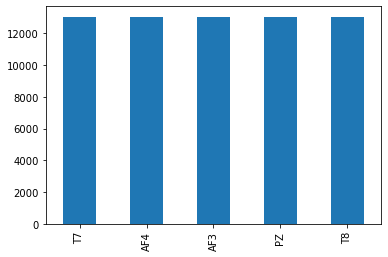

In [10]:
df.channel.value_counts().plot.bar()

In [11]:
df.code.nunique()

10

<AxesSubplot:>

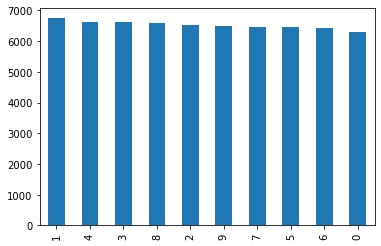

In [12]:
df.code.value_counts().plot.bar()

In [13]:
df["size"].mean()

244.13532567049808

In [14]:
df["size"].std()

31.935014214264896

### Dealing with the data values

In [15]:
df.data=df.data.apply(lambda x: [float(i) for i in x.split(",")])

In [16]:
df.data.apply(np.mean).agg(["mean","std"])

mean    4276.380742
std       37.388607
Name: data, dtype: float64

In [17]:
df.data.apply(np.std).agg(["mean","std"])

mean    19.463488
std     24.060789
Name: data, dtype: float64

In [18]:
event_id=173652
df.query(f"event=={event_id}")

,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"[4259.487179, 4237.948717, 4247.179487, 4242.0..."
1,1142044,173652,IN,AF4,0,256,"[4103.076923, 4100.51282, 4102.564102, 4087.69..."
2,1142045,173652,IN,T7,0,256,"[4245.128205, 4218.461538, 4242.051282, 4245.1..."
3,1142046,173652,IN,T8,0,256,"[4208.717948, 4188.717948, 4204.102564, 4198.4..."
4,1142047,173652,IN,PZ,0,256,"[4189.230769, 4203.589743, 4188.717948, 4186.6..."


In [19]:
# generate times column
df["time"]=df.apply(lambda row: list(np.arange(0,2,1/row.size)),axis=1)

In [20]:
def plot_event(event_id):
    df_aux=df.query(f"event=={event_id}")
    df_plot=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"])))
    plt.figure(figsize=(10,10))
    sns.lineplot(data=df_plot)
    plt.title(f"Event: {df_aux.iloc[0].event} - Digit: {df_aux.iloc[0].code}")

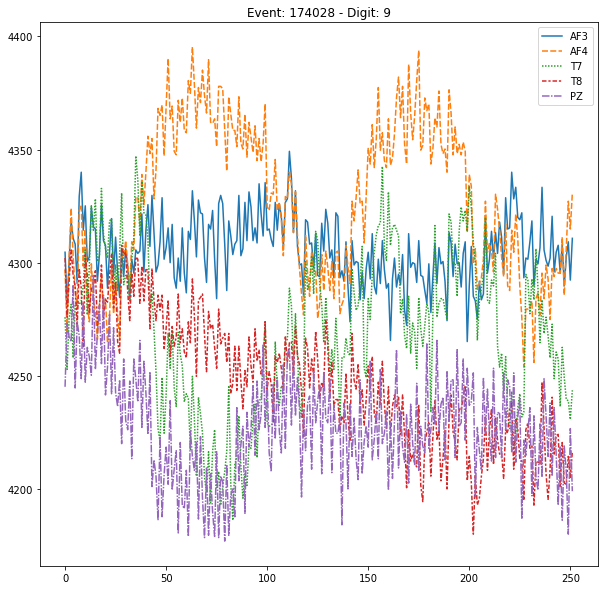

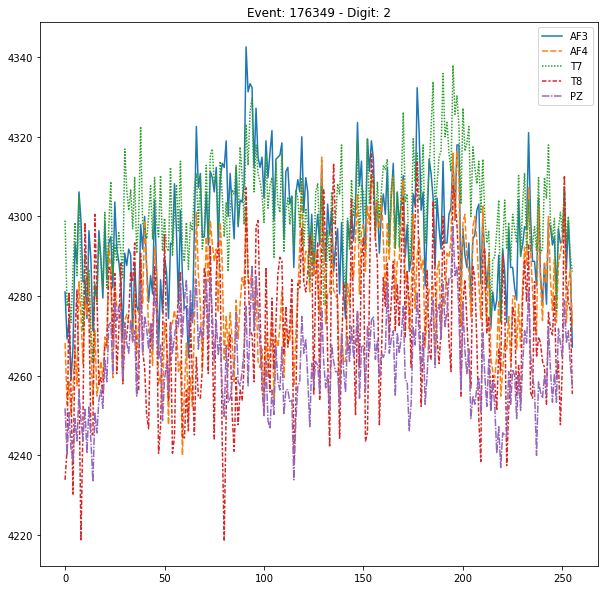

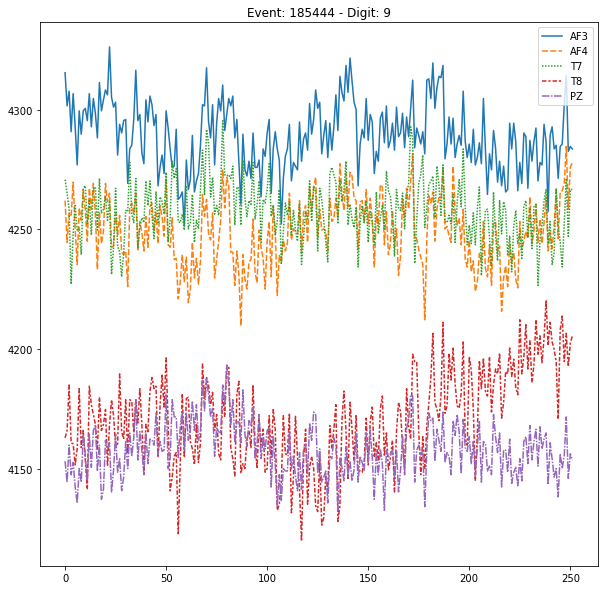

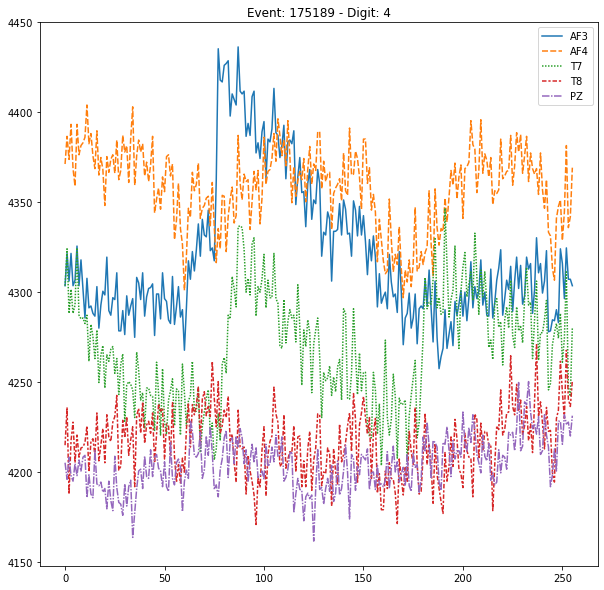

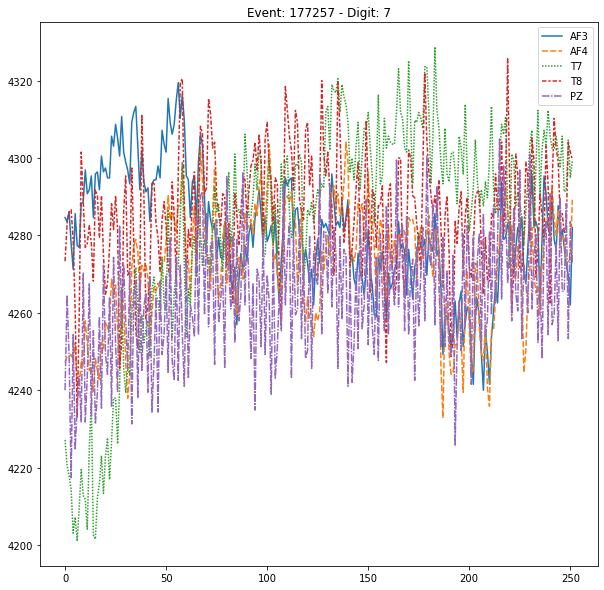

In [21]:
for ev_id in random.sample(df.event.unique().tolist(),5):
    plot_event(ev_id)

## Modeling

In [22]:
def get_sample(event_id):
    df_aux=df.query(f"event=={event_id}")
    return pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(1,5,-1)

In [23]:
get_sample(event_id).shape

(1, 5, 256)

In [24]:
def get_values_df(df_aux,resample_value=272):
    df_aux=df_aux.sort_values(by="channel")
    channels_values=pd.DataFrame(dict(zip(df_aux["channel"],df_aux["data"]))).values.T.reshape(5,-1)
    channels_values=signal.resample(channels_values,resample_value,axis=1)
    label=df_aux.code.iloc[0]
    return pd.Series({'eeg': channels_values, 'label': label}) #https://stackoverflow.com/questions/10751127/returning-multiple-values-from-pandas-apply-on-a-dataframe


In [25]:
df.head()

,id,event,device,channel,code,size,data,time
0,1142043,173652,IN,AF3,0,256,"[4259.487179, 4237.948717, 4247.179487, 4242.0...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
1,1142044,173652,IN,AF4,0,256,"[4103.076923, 4100.51282, 4102.564102, 4087.69...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
2,1142045,173652,IN,T7,0,256,"[4245.128205, 4218.461538, 4242.051282, 4245.1...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
3,1142046,173652,IN,T8,0,256,"[4208.717948, 4188.717948, 4204.102564, 4198.4...","[0.0, 0.14285714285714285, 0.2857142857142857,..."
4,1142047,173652,IN,PZ,0,256,"[4189.230769, 4203.589743, 4188.717948, 4186.6...","[0.0, 0.14285714285714285, 0.2857142857142857,..."


In [26]:
df_preprocessed=df.groupby(['event']).apply(lambda row: get_values_df(row)).reset_index()

In [27]:
## Train test split
ids_train, ids_test, y_train, y_test=train_test_split(df_preprocessed.index,df_preprocessed.label,test_size=0.2,random_state=11)

In [28]:
y_train.value_counts()/sum(y_train.value_counts())

1    0.104215
4    0.102299
8    0.101341
7    0.101149
3    0.100575
2    0.099617
9    0.099617
5    0.098755
6    0.097510
0    0.094923
Name: label, dtype: float64

In [29]:
y_test.value_counts()/sum(y_test.value_counts())

3    0.103831
0    0.103448
6    0.102299
2    0.102299
5    0.100000
9    0.099617
1    0.099617
8    0.099617
4    0.098084
7    0.091188
Name: label, dtype: float64

In [30]:
df_train=df_preprocessed.loc[ids_train].reset_index(drop=True)
df_test=df_preprocessed.loc[ids_test].reset_index(drop=True)

In [31]:
## Normalize data
NORMALIZE=True
if NORMALIZE:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaler = scaler.fit(np.concatenate(df_train.eeg.values, axis=0))

    df_train.eeg=df_train.eeg.apply(scaler.transform)
    df_test.eeg=df_test.eeg.apply(scaler.transform)

In [32]:
df_test.head()

,event,eeg,label
0,179167,"[[0.4588134844770449, 0.6617663314075795, 0.66...",9
1,174158,"[[0.2660241060743872, 0.6135065348320003, -0.0...",9
2,175959,"[[0.6087607996756665, 0.6936854341801755, 0.65...",3
3,180430,"[[0.1589188958506019, 0.08730334704609458, 0.0...",5
4,176990,"[[0.12678734322638388, -0.038194638549380655, ...",2


In [33]:
print(df_train.shape)
print(df_test.shape)

(10440, 3)
(2610, 3)


## Dataset class and dataloaders

In [34]:
fs = 272/2
nperseg=272

flatten = lambda t: [item for sublist in t for item in sublist]

def get_periodogram_all(x):
    out=[]
    for i in range(x.shape[0]):
        f, Pxx_den = signal.welch(x[i], fs, nperseg=nperseg)
        out.append(Pxx_den)
    return flatten(out)

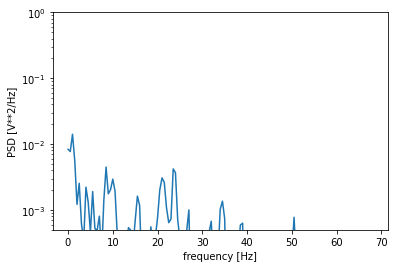

In [35]:
f, Pxx_den = signal.welch(df_train.loc[0].eeg[0], fs, nperseg=nperseg)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [36]:
df_train["welch"]=df_train.eeg.apply(get_periodogram_all)
df_test["welch"]=df_test.eeg.apply(get_periodogram_all)

In [37]:
df_train.head()

,event,eeg,label,welch
0,180187,"[[0.019682112117094003, 0.11459245236075097, 0...",4,"[0.00834093395383714, 0.0077090148028635536, 0..."
1,180942,"[[-0.9763963534059553, -0.7672687487543707, -0...",3,"[0.00017379439998989484, 0.41670400631402243, ..."
2,184457,"[[0.03039264358220773, 0.0877860488880504, 0.1...",6,"[0.0006550120691386092, 0.007374365663401339, ..."
3,183185,"[[2.7508650459205577, 2.7786875176748764, 2.34...",8,"[0.001594643899451067, 0.2009448657248832, 0.0..."
4,180542,"[[0.8336817307026942, 0.8096394049288123, 0.56...",2,"[0.054476763390799404, 0.29983293337918376, 0...."


# Model

In [38]:
from sklearn.ensemble import RandomForestClassifier

X_train=pd.DataFrame.from_records(df_train["welch"].values)
y_train=np.asarray(df_train["label"])

clf = RandomForestClassifier(n_estimators=50, random_state=0,n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)

In [39]:
y_train_pred=clf.predict(X_train)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       991
           1       1.00      1.00      1.00      1088
           2       1.00      1.00      1.00      1040
           3       1.00      1.00      1.00      1050
           4       1.00      1.00      1.00      1068
           5       1.00      1.00      1.00      1031
           6       1.00      1.00      1.00      1018
           7       1.00      1.00      1.00      1056
           8       1.00      1.00      1.00      1058
           9       1.00      1.00      1.00      1040

    accuracy                           1.00     10440
   macro avg       1.00      1.00      1.00     10440
weighted avg       1.00      1.00      1.00     10440



In [41]:
X_test=pd.DataFrame.from_records(df_test["welch"].values)
y_test=np.asarray(df_test["label"])

y_test_pred=clf.predict(X_test)

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.10      0.11      0.10       270
           1       0.10      0.13      0.11       260
           2       0.09      0.09      0.09       267
           3       0.10      0.11      0.11       271
           4       0.11      0.12      0.12       256
           5       0.09      0.08      0.08       261
           6       0.08      0.07      0.07       267
           7       0.11      0.10      0.11       238
           8       0.08      0.07      0.08       260
           9       0.11      0.08      0.09       260

    accuracy                           0.10      2610
   macro avg       0.10      0.10      0.10      2610
weighted avg       0.10      0.10      0.10      2610



In [42]:
# Hyperparameter tuning

In [43]:
# Using a random forest to optimize
from skopt import forest_minimize
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def tune_xgbc(params):
    # https://www.kaggle.com/general/17120
    # Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
    # Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_child_weight = params[3]
    gamma = params[4]
    subsample = params[5]
    colsample_bytree = params[6]


    #Model to be optimized
    mdl = xgb.XGBClassifier(learning_rate = learning_rate, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_child_weight = min_child_weight, 
                            gamma = gamma, 
                            subsample = subsample, 
                            colsample_bytree = colsample_bytree,objective = 'multi:softmax', seed = 42,n_jobs=-1)


    #Cross-Validation in order to avoid overfitting
    f1 = cross_val_score(mdl, X_train, y_train, cv = 10, scoring = 'f1_weighted')

    print(f1.mean())
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric (AUC)
    return -f1.mean()

# Creating a sample space in which the initial randomic search should be performed
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
          (100, 2000), # n_estimators
          (1, 10), # max_depth 
          (1, 6.), # min_child_weight 
          (0, 0.5), # gamma 
          (0.5, 1.), # subsample 
          (0.5, 1.)] # colsample_bytree 

# Minimization using a random forest with 20 random samples and 50 iterations for Bayesian optimization.
result = forest_minimize(tune_xgbc, space, random_state = 42, n_random_starts = 20, n_calls  = 25, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[0.03918194347141743, 1394, 8, 3.9932924209851834, 0.07800932022121827, 0.5779972601681014, 0.5290418060840998]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[08:35:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[08:45:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[08:54:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[09:04:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[09:13:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[09:23:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[09:32:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[09:41:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[09:51:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.10540103958660896
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5681.0252
Function value obtained: -0.1054
Current minimum: -0.1054
Iteration No: 2 started. Evaluating function at random point.
[0.05399484409787437, 1223, 8, 4.540362888980228, 0.010292247147901225, 0.9849549260809973, 0.916221320400211]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[10:19:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[10:38:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[10:57:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[11:15:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[11:34:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[11:53:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[12:12:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[12:31:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[12:49:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.10370204020514542
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11274.6021
Function value obtained: -0.1037
Current minimum: -0.1054
Iteration No: 3 started. Evaluating function at random point.
[0.0026587543983272693, 1315, 5, 4.087407548138583, 0.3058265802441405, 0.5035331526098588, 0.5115312125207079]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:15:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:21:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:28:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:35:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:41:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:48:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[13:54:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:01:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:07:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.10064242510046133
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3950.9141
Function value obtained: -0.1006
Current minimum: -0.1054
Iteration No: 4 started. Evaluating function at random point.
[0.011208547084229371, 610, 10, 1.2333283160680772, 0.4868777594207297, 0.6163856702151521, 0.5453032172664104]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:14:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:21:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:29:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:36:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:44:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:51:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:58:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[15:06:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[15:13:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[15:21:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.10095073980345545
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4443.1733
Function value obtained: -0.1010
Current minimum: -0.1054
Iteration No: 5 started. Evaluating function at random point.
[0.017249321573179006, 1999, 7, 5.916154429033941, 0.23338144662399002, 0.9299702033681604, 0.8401537692938899]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[16:00:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[16:31:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
result